# 3. Clusterization

### Import requiremental packages

In [43]:
import networkx as nx
import numpy as np
import pandas as pd

import scipy
from scipy.sparse import csgraph
from numpy import linalg as LA
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import SpectralClustering
import cylouvain
import matplotlib.pyplot as plt
import json
from joblib import dump, load

import utils

In [44]:
import warnings
warnings.filterwarnings('ignore')

### Read data

In [45]:
with open('data/coss_distances.json', 'r') as f:
    coss = json.loads(f.read())
    
with open('data/vectors.json', 'r') as f:
    vectors = json.loads(f.read())
    
channel_names = list(vectors.keys())

## 3.1 Define the number of clusters

In [46]:
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
#     eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

In [47]:
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

### Resources
* https://github.com/ciortanmadalina/high_noise_clustering/blob/master/spectral_clustering.ipynb
* https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f
* https://pypi.org/project/cylouvain/

my_strength [ 3  4  5  2 27]
their_weakness [ 3  5  4 13  2]
uniqueness [14  5  4 22  6]
author_kpi [ 1  2  3 14 21]
dist_kpi [ 5 12 14 20 25]
total_kpi [ 8  2 11  3  5]


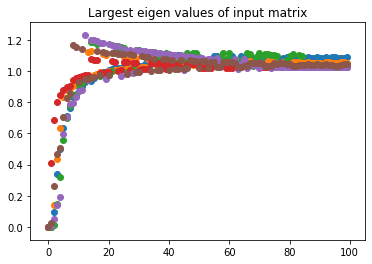

In [48]:
kpi_names = ['my_strength', 'their_weakness', 'uniqueness', 'author_kpi', 'dist_kpi', 'total_kpi']

for kpi_name in kpi_names:
    affinity_matrix = getAffinityMatrix(coss[kpi_name], k = 10)
    k, _,  _ = eigenDecomposition(affinity_matrix)
    print(kpi_name, k)

## 3.2 Spectral clustering

In [56]:
for kpi_name in kpi_names:
    adjency = np.array(coss[kpi_name])
    l_adjency = np.nan_to_num(csgraph.laplacian(adjency, normed=True), copy=True)
    
    clustering = SpectralClustering(n_clusters=5, random_state=0).fit(l_adjency)
    
    G = nx.from_numpy_matrix(l_adjency)
    for i, c in enumerate(clustering.labels_):
        nx.set_node_attributes(G, {i: c}, kpi_name)
        nx.set_node_attributes(G, {i: channel_names[i]}, "channel_name")
            
    
    # save a model
    dump(clustering, 'models/3.2_spectral_{0}.joblib'.format(kpi_name)) 
    
    # save a graph
    nx.write_gpickle(G, "graphs/3.2_spectral_{0}.gpickle".format(kpi_name), protocol=4)
    nx.write_gexf(G, "graph_pics/3.2_spectral_{0}.gexf".format(kpi_name))

In [57]:
# for weighted graph
G_weighted = nx.read_gpickle('graphs/1.3_weighted_graph.gpickle')
adjency = nx.to_numpy_matrix(G_weighted)
l_adjency = np.nan_to_num(csgraph.laplacian(adjency, normed=True), copy=True)
    
clustering = SpectralClustering(n_clusters=5, random_state=0).fit(l_adjency)

for i, c in enumerate(clustering.labels_):
    nx.set_node_attributes(G_weighted, {channel_names[i]: c}, "cluster")
            
# save a model
dump(clustering, 'models/3.2_spectral_weighted.joblib') 
    
# save a graph
nx.write_gpickle(G_weighted, "graphs/3.2_spectral_weighted.gpickle", protocol=4)
nx.write_gexf(G_weighted, "graph_pics/3.2_spectral_weighted.gexf")

## 3.3 Louvain clustering

In [40]:
for kpi_name in kpi_names:
    adjency = np.array(coss[kpi_name])
    G = nx.from_numpy_matrix(adjency)
    
    partition = cylouvain.best_partition(G)
    
    for i, c in enumerate(partition):
        nx.set_node_attributes(G, {i: c}, kpi_name)
        nx.set_node_attributes(G, {i: channel_names[i]}, "channel_name")
    
    # save a model
    dump(partition, 'models/3.3_louvain_{0}.joblib'.format(kpi_name)) 
    
    # save a graph
    nx.write_gpickle(G, "graphs/3.3_louvain_{0}.gpickle".format(kpi_name), protocol=4)
    nx.write_gexf(G, "graph_pics/3.3_louvain_{0}.gexf".format(kpi_name))

In [42]:
# for weighted graph
G_weighted = nx.read_gpickle('graphs/1.3_weighted_graph.gpickle')
    
partition = cylouvain.best_partition(G_weighted)
    
for i, c in enumerate(partition):
    nx.set_node_attributes(G_weighted, {channel_names[i]: c}, "cluster") 
            
# save a model
dump(partition, 'models/3.3_louvain_weighted.joblib') 
    
# save a graph
nx.write_gpickle(G_weighted, "graphs/3.3_louvain_weighted.gpickle", protocol=4)
nx.write_gexf(G_weighted, "graph_pics/3.3_louvain_weighted.gexf")

## 3.4 Models quality estimation

### 3.4.1 Internal evaluation

* modularity
* silhouette_score
* calinski_harabaz_score
* davies_bouldin_score

In [58]:
e_internal = pd.DataFrame(columns=['modularity', 'silhouette_score', 'calinski_harabaz_score', 'davies_bouldin_score'],
                         index=['spectral_weigthed', 'louvain_weigthed', 
                                'spectral_my_strength', 'louvain_my_strength',
                                'spectral_their_weakness', 'louvain_their_weakness',
                                'spectral_uniqueness', 'louvain_uniqueness', 
                                'spectral_author_kpi', 'louvain_author_kpi', 
                                'spectral_dist_kpi', 'louvain_dist_kpi',  
                                'spectral_total_kpi', 'louvain_total_kpi'])

filenames = {'spectral_weigthed': '3.2_spectral_weighted', 'louvain_weigthed': '3.3_louvain_weighted',
             'spectral_my_strength': '3.2_spectral_my_strength', 
             'spectral_their_weakness': '3.2_spectral_their_weakness', 'spectral_uniqueness': '3.2_spectral_uniqueness', 
             'spectral_author_kpi': '3.2_spectral_author_kpi', 
             'spectral_dist_kpi': '3.2_spectral_dist_kpi', 'spectral_total_kpi': '3.2_spectral_total_kpi', 
             'louvain_my_strength': '3.3_louvain_my_strength', 'louvain_their_weakness': '3.3_louvain_their_weakness', 
             'louvain_uniqueness': '3.3_louvain_uniqueness', 
             'louvain_author_kpi': '3.3_louvain_author_kpi', 'louvain_dist_kpi': '3.3_louvain_dist_kpi', 
             'louvain_total_kpi': '3.3_louvain_total_kpi'}


for k, v in filenames.items():
    model = load('models/{0}.joblib'.format(v))
    G = nx.read_gpickle('graphs/{0}.gpickle'.format(v))
    matrix = nx.to_numpy_matrix(G)

    if 'louvain_' in v:
        clusters = model
        
        modularity = cylouvain.modularity(clusters, G)
        estimators = utils.internalValidation(matrix, [v for k, v in clusters.items()])
    else:
        clusters = model.labels_
        
        modularity = nx.algorithms.community.modularity(G, [{node: clusters[i]} for i, node in enumerate(G.nodes())])
        estimators = utils.internalValidation(matrix, clusters)
        
    e_internal['modularity'][k] = modularity
    e_internal['silhouette_score'][k] = estimators['_silhouette_score']
    e_internal['calinski_harabaz_score'][k] = estimators['_calinski_harabaz_score']
    e_internal['davies_bouldin_score'][k] = estimators['_davies_bouldin_score']

e_internal

,modularity,silhouette_score,calinski_harabaz_score,davies_bouldin_score
spectral_weigthed,-0.0183529,0.0148307,2.91602,2.44996
louvain_weigthed,0.335296,-0.169756,3.93369,2.70981
spectral_my_strength,1.79732,0.00232392,1.03317,1.80411
louvain_my_strength,0.0779005,0.0863935,22.314,1.29734
spectral_their_weakness,1.76902,-0.00266084,1.00009,3.48916
louvain_their_weakness,0.0751391,0.0552681,17.7253,1.49726
spectral_uniqueness,1.62898,0.0260392,1.21571,1.39766
louvain_uniqueness,0.0650882,0.207633,17.7294,1.21126
spectral_author_kpi,1.8445,-0.00347799,1.0148,4.13686
louvain_author_kpi,0.278538,0.112184,8.19885,1.16404


### 3.4.2 External evaluation

* _rand_index
* _homogeneity_score
* _purity_score
* _adjusted_mutual_info_score
* _fowlkes_mallows_score

In [59]:
e_external = pd.DataFrame(columns=['rand_index', 'homogeneity_score', 'adjusted_mutual_info_score', 'fowlkes_mallows_score'],
                         index=['spectral_my_strength', 'louvain_my_strength',
                                'spectral_their_weakness', 'louvain_their_weakness',
                                'spectral_uniqueness', 'louvain_uniqueness', 
                                'spectral_author_kpi', 'louvain_author_kpi', 
                                'spectral_dist_kpi', 'louvain_dist_kpi',  
                                'spectral_total_kpi', 'louvain_total_kpi'])

filenames = {'spectral_my_strength': '3.2_spectral_my_strength', 
             'spectral_their_weakness': '3.2_spectral_their_weakness', 'spectral_uniqueness': '3.2_spectral_uniqueness', 
             'spectral_author_kpi': '3.2_spectral_author_kpi', 
             'spectral_dist_kpi': '3.2_spectral_dist_kpi', 'spectral_total_kpi': '3.2_spectral_total_kpi', 
             'louvain_my_strength': '3.3_louvain_my_strength', 'louvain_their_weakness': '3.3_louvain_their_weakness', 
             'louvain_uniqueness': '3.3_louvain_uniqueness', 
             'louvain_author_kpi': '3.3_louvain_author_kpi', 'louvain_dist_kpi': '3.3_louvain_dist_kpi', 
             'louvain_total_kpi': '3.3_louvain_total_kpi'}

model = load('models/3.2_spectral_weighted.joblib')
spectral_null = model.labels_
             
model = load('models/3.3_louvain_weighted.joblib')
louvain_null = [v for k, v in model.items()]


for k, v in filenames.items():
    model = load('models/{0}.joblib'.format(v))

    if 'louvain_' in v:
        clusters = model
        estimators = utils.externalValidation(louvain_null, [v for k, v in clusters.items()])
    else:
        clusters = model.labels_
        estimators = utils.externalValidation(spectral_null, clusters)
        
    e_external['rand_index'][k] = estimators['_rand_index']
    e_external['homogeneity_score'][k] = estimators['_homogeneity_score']
    # e_external['purity_score'][k] = estimators['_purity_score']
    e_external['adjusted_mutual_info_score'][k] = estimators['_adjusted_mutual_info_score']
    e_external['fowlkes_mallows_score'][k] = estimators['_fowlkes_mallows_score']

e_external

,rand_index,homogeneity_score,adjusted_mutual_info_score,fowlkes_mallows_score
spectral_my_strength,-0.0250306,0.0511688,0.00421431,0.70913
louvain_my_strength,0.0164394,0.0625062,0.00223105,0.28965
spectral_their_weakness,-0.122413,0.050485,-0.0162526,0.606886
louvain_their_weakness,0.00483757,0.0721738,-0.00147661,0.272592
spectral_uniqueness,0.119401,0.148283,0.108473,0.760084
louvain_uniqueness,-0.0211666,0.216441,-0.00541081,0.220809
spectral_author_kpi,-0.0704647,0.103896,0.0361316,0.547032
louvain_author_kpi,0.0198206,0.117768,-0.00387399,0.250986
spectral_dist_kpi,0.00351347,0.0466625,0.005682,0.732886
louvain_dist_kpi,-0.00832401,0.256632,-0.0033223,0.20803
